In [84]:
# begin with some imports 
import matplotlib.pyplot as plt
import matplotlib.patheffects as pe
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

# load data -- this analysis will look only at australia-wide data, no state specific info
data_energy_demographics = pd.read_excel('aus_energy_table_b.xlsx', sheet_name='AUS', skiprows=4, header=None)
data_energy_type = pd.read_excel('aus_energy_table_c.xlsx', sheet_name='AUS', skiprows=4, header=None)

# Australian Energy Market Analysis (Part 2)

This notebook continues our exploration of Australia's energy landscape, focusing on correlation analysis, renewable energy integration trends, and future projections. We'll examine the relationships between various economic indicators and energy sources, visualize the growing role of renewables, and model potential future scenarios for Australia's energy mix.

In [85]:
# Load raw data
df1_raw = data_energy_demographics.copy()
df2_raw = data_energy_type.copy()

# Build columns by combining name/unit rows
columns1 = df1_raw.iloc[0].astype(str) + " (" + df1_raw.iloc[1].astype(str) + ")"
columns2 = df2_raw.iloc[0].astype(str) + " (" + df2_raw.iloc[1].astype(str) + ")"

# Slice actual data (from row 2 onward)
df1 = df1_raw.iloc[2:].copy()
df2 = df2_raw.iloc[2:].copy()

# Apply clean headers
df1.columns = columns1
df2.columns = columns2

# Extract and set year column (before any drops)
years1 = df1_raw.iloc[2:, 1].values
years2 = df2_raw.iloc[2:, 1].values
df1.insert(0, 'Year', years1)
df2.insert(0, 'Year', years2)

# Set Year as index
df1.set_index('Year', inplace=True)
df2.set_index('Year', inplace=True)

# Drop first two metadata columns
df1.drop(df1.columns[:2], axis=1, inplace=True)
df2.drop(df2.columns[:2], axis=1, inplace=True)

# Optional: drop footer rows if truly junk
df1 = df1.iloc[:-6]
df2 = df2.iloc[:-6]

# Convert to numeric
df1 = df1.apply(pd.to_numeric, errors='coerce').round(1)
df2 = df2.apply(pd.to_numeric, errors='coerce').round(1)

# Clean output display
pd.set_option('display.float_format', '{:.1f}'.format)

# fillna values with 0
#df1.fillna(0, inplace=True)
#df2.fillna(0, inplace=True)


## Data Preparation

Before diving into advanced analysis, we need to prepare our datasets. The process involves:

1. Loading the raw data from Excel files
2. Cleaning and structuring the column headers by combining name and unit rows
3. Setting the year as the index for time-series analysis
4. Converting data types to numeric values
5. Removing footer rows with non-data content

This clean dataset will form the foundation for our correlation analysis and visualizations.

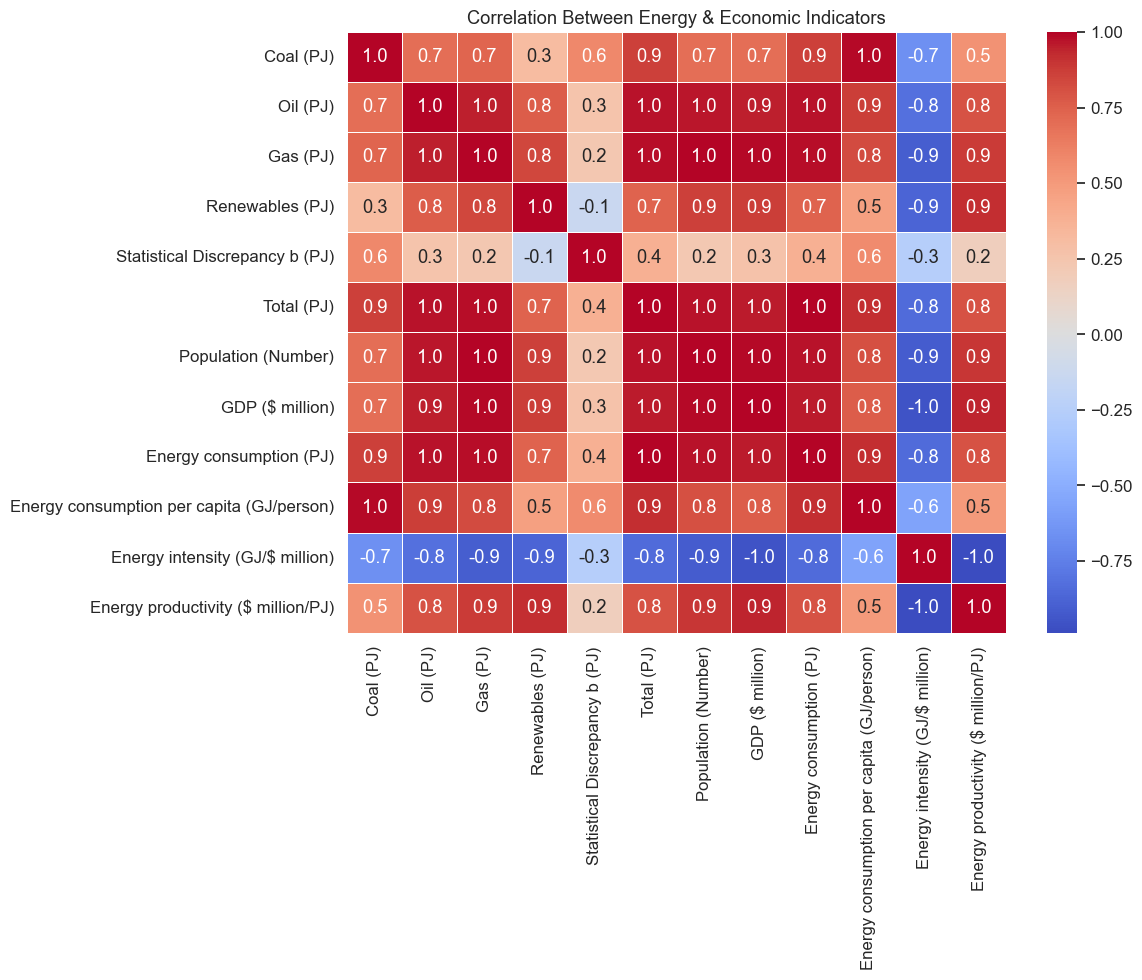

In [86]:
# Combine df1 and df2
df_corr = df1.join(df2, how='inner')

# Filter only numeric columns
df_corr_numeric = df_corr.select_dtypes(include='number')

# Correlation matrix
corr_matrix = df_corr_numeric.corr()

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".1f", linewidths=0.5)
plt.title('Correlation Between Energy & Economic Indicators')
plt.tight_layout()
plt.show()


## Correlation Analysis

To understand the relationships between energy consumption patterns and economic indicators, we'll create a correlation matrix. This visualization will reveal how different variables interact with each other, highlighting potential causal relationships and dependencies.

Strong positive correlations (close to 1) indicate variables that increase together, while strong negative correlations (close to -1) suggest inverse relationships. Values near zero indicate little to no linear relationship.

# 📊 Key Insights from Australia's Energy & Economic Correlations

### Efficiency and Productivity
**Energy productivity and intensity are perfect opposites:** As Australia becomes more energy-efficient (lower GJ per $ million), its energy productivity ($ million per PJ) improves dramatically. This inverse relationship (correlation = –1.0) confirms that efficiency gains directly translate to economic value per unit of energy.

### Economic Growth and Energy Consumption
**Economic growth remains tightly coupled with energy use:** GDP, population, and total energy consumption all show near-perfect positive correlations (0.9–1.0), suggesting that Australia's economic expansion continues to depend heavily on energy demand, without significant decoupling yet.

### Renewable Energy Transition
**Renewables are rising, but not yet replacing fossil fuels:** Renewable energy shows moderate-to-high correlation with oil and gas, but only weak correlation with coal. This indicates that renewables are supplementing, not yet displacing, fossil fuels — especially coal, which remains poorly aligned with broader energy or economic performance.

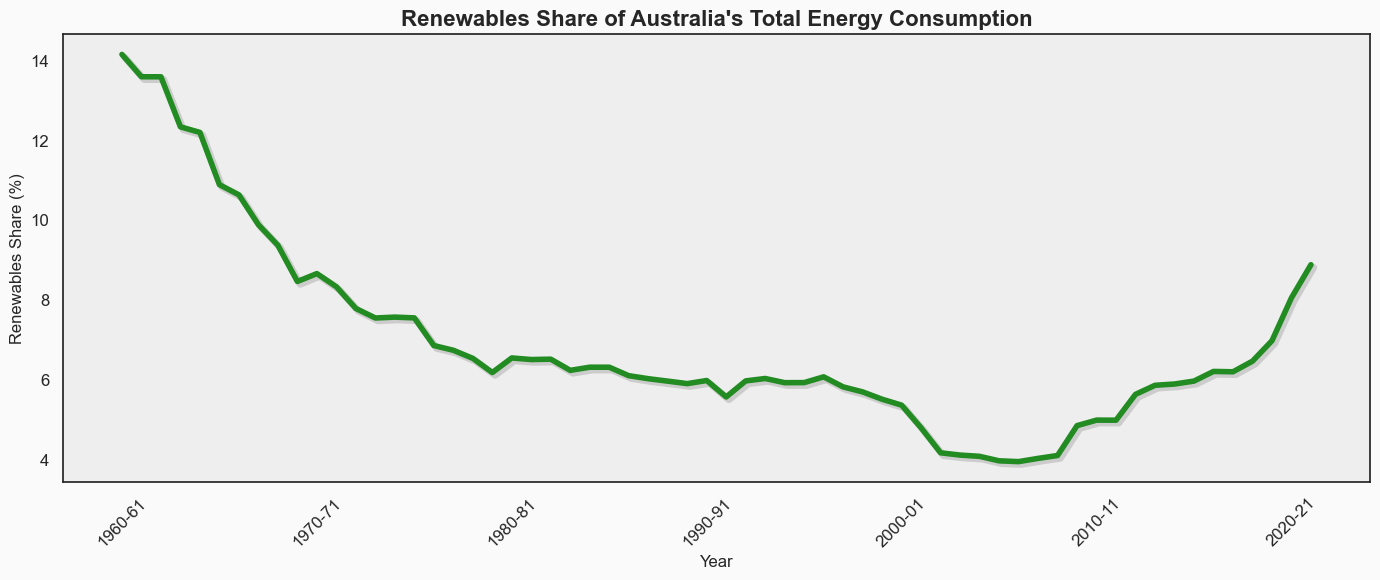

In [87]:
# Prepare data
df_share = df1.copy()
df_share['Renewables Share (%)'] = df_share['Renewables (PJ)'] / df_share['Total (PJ)'] * 100
df_share = df_share.reset_index()

# Use clean white style first, then custom background
sns.set_style("white")

# Build plot
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('#fafafa')       # Light grey background
ax.set_facecolor('#eeeeee')

# Lineplot (no markers)
line = sns.lineplot(
    data=df_share,
    x='Year',
    y='Renewables Share (%)',
    color='forestgreen',
    linewidth=4,
    ax=ax
)

# Path effect for subtle line depth
line.lines[0].set_path_effects([
    pe.SimpleLineShadow(shadow_color='gray', alpha=0.3, linewidth=5),
    pe.Normal()
])

# Show every 10th year only
year_labels = df_share['Year']
step = 10
ax.set_xticks(range(0, len(year_labels), step))
ax.set_xticklabels(year_labels[::step], rotation=45)

# Titles & axis styling
ax.set_title("Renewables Share of Australia's Total Energy Consumption", fontsize=16, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Renewables Share (%)", fontsize=12)

plt.tight_layout()
plt.show()


## Renewable Energy Share Analysis

This visualization tracks the percentage of renewable energy within Australia's total energy consumption over time. The smooth, styled line chart with custom background and drop shadow effects provides a clear view of Australia's progress toward renewable energy adoption.

By calculating renewables as a percentage of total energy consumption rather than looking at absolute values, we can better understand the relative importance of renewable energy sources in the national energy mix and track the pace of energy transition.

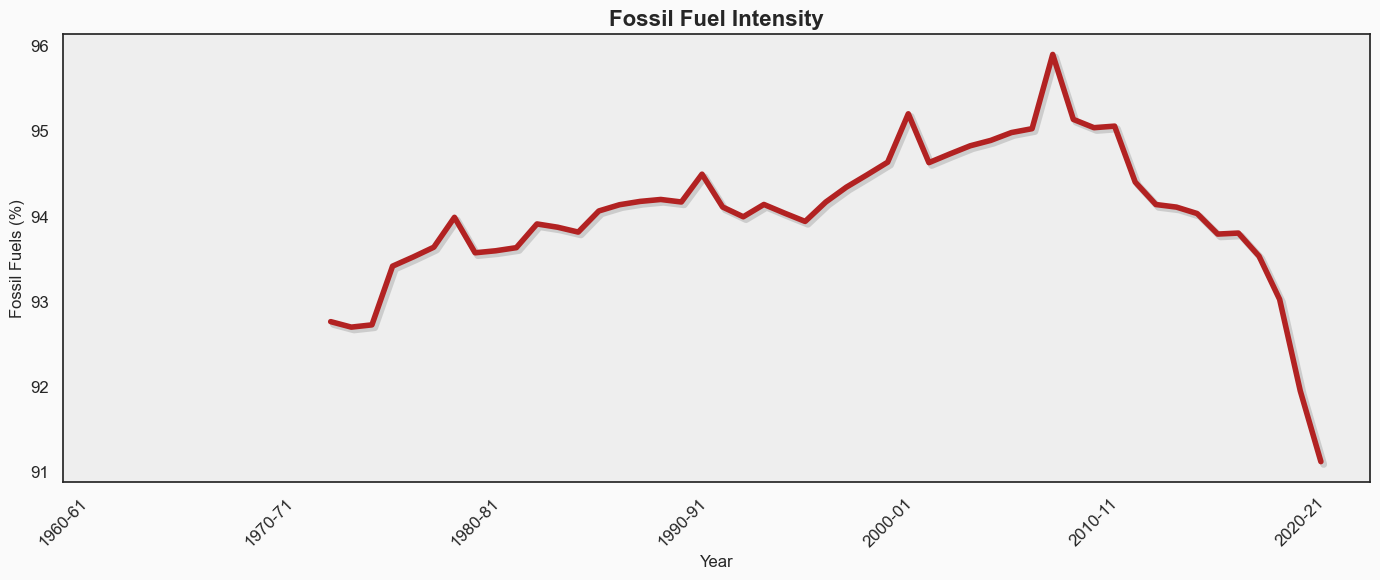

In [88]:
# Prepare data
df_carbon = df1.copy()
df_carbon['Carbon Intensity Proxy (%)'] = ((df_carbon['Coal (PJ)'] + df_carbon['Oil (PJ)'] + df_carbon['Gas (PJ)']) / df_carbon['Total (PJ)']) * 100
df_carbon = df_carbon.reset_index()

# Use clean white style first, then custom background
sns.set_style("white")

# Build plot
fig, ax = plt.subplots(figsize=(14, 6))
fig.patch.set_facecolor('#fafafa')       # Light grey background
ax.set_facecolor('#eeeeee')

# Lineplot (no markers)
line = sns.lineplot(
    data=df_carbon,
    x='Year',
    y='Carbon Intensity Proxy (%)',
    color='firebrick',
    linewidth=4,
    ax=ax
)

# Path effect for subtle line depth
line.lines[0].set_path_effects([
    pe.SimpleLineShadow(shadow_color='gray', alpha=0.3, linewidth=5),
    pe.Normal()
])

# Show every 10th year only
year_labels = df_carbon['Year']
step = 10
ax.set_xticks(range(0, len(year_labels), step))
ax.set_xticklabels(year_labels[::step], rotation=45)

# Titles & axis styling
ax.set_title("Fossil Fuel Intensity", fontsize=16, weight='bold')
ax.set_xlabel("Year", fontsize=12)
ax.set_ylabel("Fossil Fuels (%)", fontsize=12)

plt.tight_layout()
plt.show()


## Fossil Fuel Intensity

This visualization examines the fossil fuel intensity of Australia's energy mix over time. By calculating the percentage of energy derived from coal, oil, and gas combined, we create a proxy for carbon intensity in the energy system.

The styled visualization with custom visual effects helps illustrate long-term trends in Australia's dependency on fossil fuels and provides context for understanding the country's energy transition challenges and opportunities.

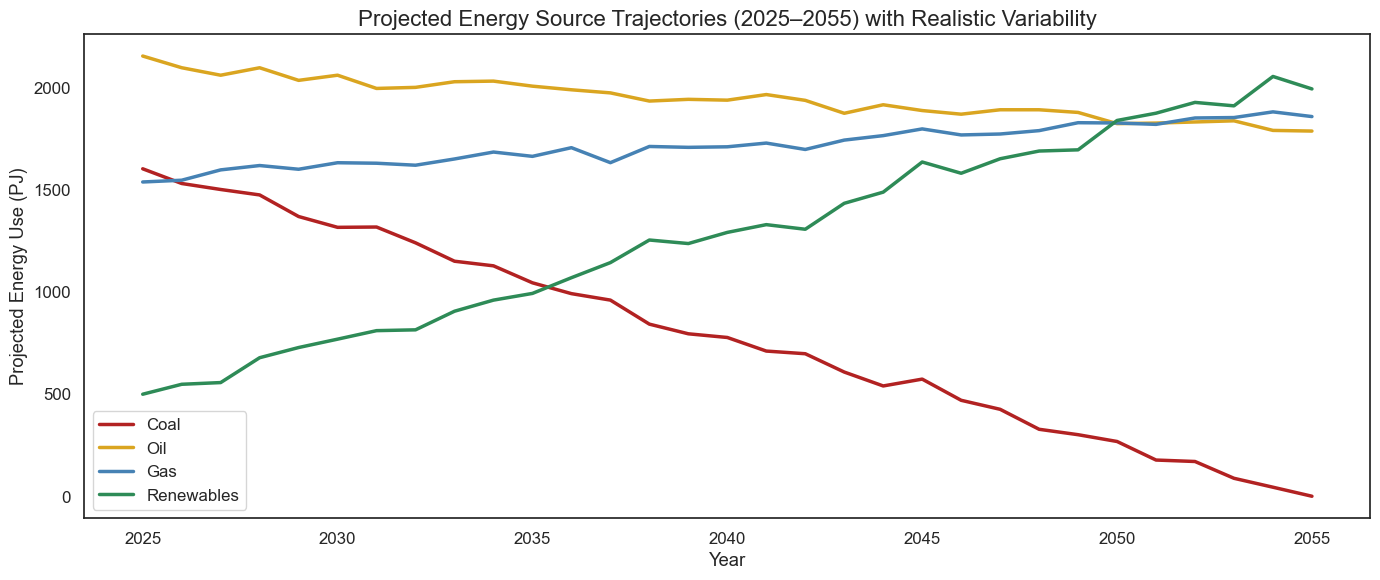

In [96]:
# fillna values with 0
df1.fillna(0, inplace=True)
df2.fillna(0, inplace=True)

# Define future years
future_years = np.arange(2025, 2056)

# Extract last known values from df1
last_values = df1[['Coal (PJ)', 'Oil (PJ)', 'Gas (PJ)', 'Renewables (PJ)']].iloc[-1]

# Set random seed for reproducibility
np.random.seed(42)

# Define base trend directions + add noise
coal_proj = np.linspace(last_values['Coal (PJ)'], 0, len(future_years)) + np.random.normal(0, 30, len(future_years))
oil_proj = np.linspace(last_values['Oil (PJ)'], last_values['Oil (PJ)'] * 0.85, len(future_years)) + np.random.normal(0, 25, len(future_years))
gas_proj = np.linspace(last_values['Gas (PJ)'], last_values['Gas (PJ)'] * 1.2, len(future_years)) + np.random.normal(0, 20, len(future_years))
renewables_proj = np.linspace(last_values['Renewables (PJ)'], last_values['Renewables (PJ)'] * 4, len(future_years)) + np.random.normal(0, 40, len(future_years))

# Build DataFrame
df_proj = pd.DataFrame({
    'Year': future_years,
    'Coal (PJ)': np.clip(coal_proj, 0, None),
    'Oil (PJ)': np.clip(oil_proj, 0, None),
    'Gas (PJ)': np.clip(gas_proj, 0, None),
    'Renewables (PJ)': np.clip(renewables_proj, 0, None),
})

# Plot
plt.figure(figsize=(14, 6))
plt.plot(df_proj['Year'], df_proj['Coal (PJ)'], label='Coal', color='firebrick', linewidth=2.5)
plt.plot(df_proj['Year'], df_proj['Oil (PJ)'], label='Oil', color='goldenrod', linewidth=2.5)
plt.plot(df_proj['Year'], df_proj['Gas (PJ)'], label='Gas', color='steelblue', linewidth=2.5)
plt.plot(df_proj['Year'], df_proj['Renewables (PJ)'], label='Renewables', color='seagreen', linewidth=2.5)

plt.title("Projected Energy Source Trajectories (2025–2055) with Realistic Variability", fontsize=16)
plt.xlabel("Year")
plt.ylabel("Projected Energy Use (PJ)")
plt.legend()
plt.tight_layout()
plt.show()

## Future Energy Projections

This section projects potential future trajectories for Australia's energy mix from 2025 to 2055. Using the latest available data points as our starting reference, we model several scenarios with these assumptions:

- **Coal**: Projected to gradually phase out completely by 2055
- **Oil**: Expected to decline moderately to 85% of current levels
- **Gas**: Projected to increase by 20% as a transitional fuel
- **Renewables**: Expected to grow substantially, reaching 4x current capacity

Realistic variability is incorporated through controlled random noise, reflecting the unpredictable nature of energy markets, technological breakthroughs, and policy changes. This simulation provides a data-driven glimpse into Australia's potential energy future.

## Conclusion: Australia's Energy Transition

Our analysis of Australia's energy landscape reveals several key insights about the past, present, and potential future of the country's energy system:

### Current State and Historical Trends

1. **Fossil Fuel Dependency**: Despite progress in renewable adoption, Australia's energy mix remains heavily dominated by fossil fuels, with coal, oil, and gas accounting for the vast majority of energy consumption.

2. **Economic-Energy Coupling**: The strong correlation between GDP growth and energy consumption suggests that Australia has not yet achieved significant decoupling of economic growth from energy use.

3. **Efficiency Improvements**: The inverse relationship between energy intensity and productivity demonstrates that Australia is becoming more efficient in how it uses energy to generate economic output.

### Transition Dynamics

1. **Renewable Growth**: The share of renewables in Australia's energy mix has been growing, but from a relatively low base. The rate of growth has accelerated in recent years.

2. **Supplementation vs. Replacement**: Our correlation analysis suggests that renewables are currently supplementing rather than replacing fossil fuels—especially coal, which shows weak correlation with renewable growth.

3. **Carbon Intensity**: The fossil fuel intensity visualization shows only modest declines, indicating that much more rapid transformation is needed to align with global climate goals.

### Future Outlook

1. **Projected Energy Mix**: Our modeling suggests that with current trends extended and accelerated, Australia could see a dramatically different energy landscape by 2055, with renewables potentially becoming the dominant energy source.

2. **Transitional Role of Gas**: The projection indicates a potential increased role for natural gas as a bridge fuel during the transition period.

3. **Coal Phase-Out**: The complete phase-out of coal from Australia's energy mix by 2055 would represent a historic shift for a country that has been among the world's leading coal producers and consumers.

These findings underscore both the significant challenges and opportunities facing Australia as it navigates its energy transition in the coming decades. The pace and extent of this transition will be influenced by technological innovation, policy decisions, global energy markets, and societal priorities regarding climate change and economic development.